In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import py_vollib.black_scholes.implied_volatility as impl

In [2]:
gamma1=1.1
gamma2=20
lambda1=10
lambda2=10
beta1=0.005
beta2=0.001
kappa=0.5
cdf=norm.cdf
alpha0=0.5

In [3]:
def kfct(t,x,sigma):
    return(np.exp(-x**2/(2*t*sigma**2)-t*sigma**2/8))
    

In [4]:
def lambd(t,x):
    return((t<=0.1)/(1+0.1*t)**lambda2*np.minimum((gamma1*np.maximum(x-beta1,0)+gamma2*np.maximum(-x-beta2,0))**kappa,lambda1))

In [5]:
def azeta_sq(t,x,p0=0.3,p1=0.5,p2=0.2,sigma0=0.4,sigma1=0.3,sigma2=0.6):
    tmp=p0*sigma0*kfct(t,x,sigma0)+p1*sigma1*kfct(t,x,sigma1)+p2*sigma2*kfct(t,x,sigma2)+lambd(t,x)
    tmp=tmp*(1-0.6*(t>0.1))
    tmp2=p0/sigma0*kfct(t,x,sigma0)+p1/sigma1*kfct(t,x,sigma1)+p2/sigma2*kfct(t,x,sigma2)+0.01
    return(np.sqrt(abs(tmp/tmp2)))

In [6]:
def S_traj(samples=1000,N=100,p0=0.3,p1=0.5,p2=0.2,sigma0=0.4,sigma1=0.3,sigma2=0.6):
    dt=1/N
    incr=np.random.normal(0,np.sqrt(dt),[samples,N])
    X=np.zeros([samples,N+1])
    vols=np.zeros([samples,N])
    for i in range(N):
        sigmas=np.minimum(azeta_sq((i+1)*dt,X[:,i],p0,p1,p2,sigma0,sigma1,sigma2),np.sqrt(2))
        vols[:,i]=sigmas
        dX=-0.5*alpha0**2*sigmas**2*dt+alpha0*sigmas*incr[:,i]
        X[:,i+1]=X[:,i]+dX
        #print(X[i])
    return(np.exp(X),vols)

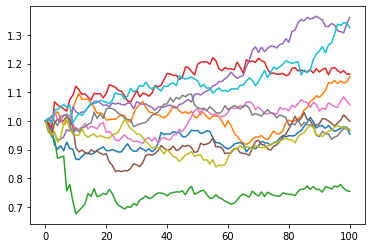

In [7]:
[tmp,tmpvol]=S_traj(samples=10)
tmp=plt.plot(tmp.T)

In [8]:
def delta(S, vols, K=1.0, T=1.0):
    """Compute delta hedging portfolio for given sample trajectories"""
    N = S.shape[1] - 1
    H = np.zeros(shape=(len(S), N))
    for j in range(N):
        H[:, j] = delta_hedge(T*j/N, S[:, j], K, vols[:,j], T)
    return H

In [9]:
def bInt(H, X):
    """
    Batch vectorized 1D integration.
    H should be of shape (samples, N-1)
    X should be of shape (samples, N)
    with N being length of path.
    """
    return np.cumsum(H * np.diff(X, axis=1), axis=1)

In [10]:
cdf=norm.cdf
def delta_hedge(t, S, K, vol, T):
    """Compute BS delta at a given timepoint and price point"""
    return cdf((np.log(S/K)-0.5*(T-t)*vol**2)/(0.00001+np.sqrt(T-t)*vol))

In [11]:
def opt_price(finvals,bInt,K=1):
    return(np.mean(np.maximum(finvals-K,0)-bInt[:,-1]))

In [12]:
times=np.array([0.15,0.25,0.5,1.0])
ks=np.array([0.1,0.2,0.3,0.5])
strikes=np.zeros([4,20])
strikes[:,0]=np.exp(-1*ks)
strikes[:,-1]=np.exp(ks)
dstrikes=(strikes[:,-1]-strikes[:,0])/19
def calc_prices(samplenr=1000,p0=0.3,p1=0.5,p2=0.2,sigma0=0.4,sigma1=0.3,sigma2=0.6):
    for i in range(18):
        strikes[:,(i+1)]=strikes[:,i]+dstrikes
    [S,vols]=S_traj(samples=samplenr,N=100)
    prices=np.zeros([4,20])
    for i in range(4):
        for j in range(20):
            H=delta(S,vols,K=strikes[i,j],T=times[i])
            HS=bInt(H,S)
            prices[i,j]=opt_price(S[:,-1],HS,strikes[i,j])
    return(prices,S,vols)

In [88]:
M=3
prices=np.zeros([M,4,20])
samplenr=100000
#S=np.zeros([M,samplenr,101])
#vols=np.zeros([M,samplenr,100])
for m in range(M):
    #print(m)
    p1=np.random.uniform(0.4,0.5)
    p2=np.random.uniform(0.5,0.7)
    #if (p1+p2>1):
        #p2=1-p1
    p0=np.absolute(1-p1-p2)
    sigma0=np.random.uniform(0.5,1.7)
    sigma1=np.random.uniform(0.2,0.4)
    sigma2=np.random.uniform(0.5,1.7)
    prices[m,:,:]=calc_prices(samplenr=samplenr,p0=p0,p1=p1,p2=p2,sigma0=sigma0,sigma1=sigma1,sigma2=sigma2)[0]

In [89]:
implvol=np.zeros([M,4,20])
for m in range(M):
    for j in range(4):
        for i in range(20):
            #print(i)
            implvol[m,j,i]=impl.implied_volatility(prices[m,j,i],1,strikes[j,i],times[j],0,'c')

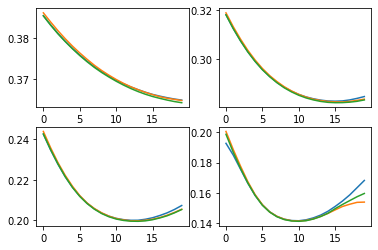

In [90]:
fig,axs=plt.subplots(2,2)
tmp0=axs[0,0].plot(implvol[:,0,:].T)
tmp1=axs[0,1].plot(implvol[:,1,:].T)
tmp2=axs[1,0].plot(implvol[:,2,:].T)
tmp3=axs[1,1].plot(implvol[:,3,:].T)

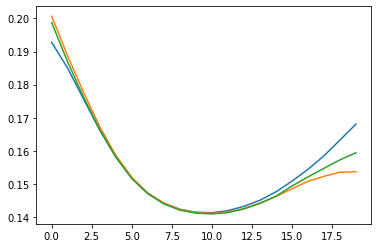

In [91]:
tmp=plt.plot(implvol[:,3,:].T)

In [15]:
tmp=calc_prices()[0]
tmp

array([[ 1.16371448e-01,  1.08511053e-01,  1.01009825e-01,
         9.37857633e-02,  8.67973245e-02,  8.01901245e-02,
         7.39379150e-02,  6.80541071e-02,  6.24813923e-02,
         5.72292109e-02,  5.22277100e-02,  4.75538843e-02,
         4.32146754e-02,  3.92434277e-02,  3.55155417e-02,
         3.20568772e-02,  2.88480197e-02,  2.59565822e-02,
         2.33402004e-02,  2.09452264e-02],
       [ 1.88481750e-01,  1.69609511e-01,  1.51471286e-01,
         1.34071136e-01,  1.17512576e-01,  1.02064134e-01,
         8.78149721e-02,  7.48648945e-02,  6.32308862e-02,
         5.27881987e-02,  4.36027677e-02,  3.57196706e-02,
         2.89030219e-02,  2.32556359e-02,  1.85194431e-02,
         1.45948910e-02,  1.14254191e-02,  8.81737452e-03,
         6.82283861e-03,  5.22060844e-03],
       [ 2.61893381e-01,  2.31207641e-01,  2.01262488e-01,
         1.72400774e-01,  1.45043395e-01,  1.19637255e-01,
         9.66740585e-02,  7.64243061e-02,  5.89761133e-02,
         4.43288191e-02,  3.2

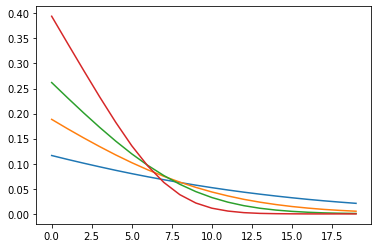

In [16]:
plt.plot(tmp.T)